In [1]:
import os
import requests
import json
import yfinance as yf
from bs4 import BeautifulSoup
from lxml import etree
from datetime import datetime
from matplotlib import pyplot as plt
import requests
import pandas as pd
import numpy as np
import datetime
import json
import time

### Gather all the SP500 & financial indicator ticker symbols through Wikipedia

In [3]:
## sp500 stocks 
all_tickers_xpath = "//span[text() = \"S&P 500 component stocks\"]/following::tbody[1]/tr/td[1]/a"
soup = BeautifulSoup(requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").content, 'html.parser')
dom = etree.HTML(str(soup))

# find all tickers
all_tickers = [i.text for i in dom.xpath(all_tickers_xpath)]

# look at the first 5 ticker symbols
print("The first 5 ticker symbols:")
print(all_tickers[:5])

# also gather all financial indicator symbols

"""
    Here are some of the useful Market indices to track:
    
    Gold futures and spot prices are a great way to see how the dollar is 
    changing over a certain period of time, which is reflective of inflation 
    and market sentiment through futures.

    Crude oil prices influence the cost of production and manufacturing across
    the country. Reduction of oil prices directly affect the consumer at a large
    scale, as there is a greater discretionary income available, serving as a
    stimulant for the economy.

    The SP500 index tracks the general trend of the SP500 market. This index
    value is very helpful when trying to predict price movements because it
    is like an estimate of overall market trends.

    Market Volatility Index reflects a volatility measure for the next 30 days.
    "VIX values >= 30 are linked to volatility from uncertainty, risk, and
    investors' fear. VIX values below 20 correspond to stable, stress-free
    period in the markets."

    US Dollar Index measures the value of the US dollar in relation to a
    collection of foreign currencies. The base value of this index is 100
    and values are interpreted relative to that base. (we can standardize)
        if the index is above 100, the dollar is stronger compared to the
        other currencies. otherwise the opposite reflects inverse relation-
        ship.

    Copper is used across technology, energy, and construction. These prices
    will capture a baseline econoimc condition, where rising copper prices
    may indicate inflation or tightening economic conditions.
"""

# Gold Futures
all_tickers.append("GC=F")

# Gold Spot Prices (SPDR GLD tracks the price of the gold bullion OTC market)
all_tickers.append("GLD")

# Crude Oil Futures
all_tickers.append("CL=F")

# SP500 index (relevant to the entire sector)
all_tickers.append("^GSPC")

# Market Volatility Index
all_tickers.append("^VIX")

# US dollar index
all_tickers.append("DX-Y.NYB")

# Copper futures
all_tickers.append("HG=F")

The first 5 ticker symbols:
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']


### Gather all stock market data for every ticker symbol on the SP500

In [ ]:
# yfinance is very convenient and allows us to do this in one function call
tickers_df = yf.download(' '.join(all_tickers), group_by='tickers')
tickers_df.to_csv('stock_ticker_data.csv')

In [ ]:
# some summary statistics for the ticker data
rows_cnt, col_cnt = np.shape(tickers_df)
print('Number of rows:', rows_cnt, 'Number of cols:', col_cnt)

# see the last bit of data for the group ticker symbols
tickers_df.tail()

### Gathering Congressional trade data

In [ ]:
# ~ 17,000 + 8,000 congressional trading data (pretty useful for all raw data from House)
# we have to transform this data into something useful, will research into that later
# https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json
# https://senate-stock-watcher-data.s3-us-west-2.amazonaws.com/aggregate/all_transactions.json

In [7]:
house_trade_data = requests.get("https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json")
senate_trade_data = requests.get("https://senate-stock-watcher-data.s3-us-west-2.amazonaws.com/aggregate/all_transactions.json")

In [13]:
# extract all the useful information from congressional trading data
house_json, senate_json = house_trade_data.json(), senate_trade_data.json()
house_df, senate_df = pd.DataFrame(house_json), pd.DataFrame(senate_json)

house_df = house_df[['ticker', 'type', 'amount', 'disclosure_date', 'representative', 'sector', 'party']]
senate_df = senate_df[['ticker', 'type', 'amount', 'disclosure_date', 'senator', 'sector', 'party']]

colnames = ['ticker', 'type', 'amount', 'disclosure_date', 'person', 'sector', 'party']
house_df.columns = colnames
senate_df.columns = colnames

congressional_df = pd.concat([house_df, senate_df])
congressional_df.to_csv('congressional_data.csv')

del house_json, senate_json, house_df, senate_df

### Gathering all required textual data (for sentiment/ market condition embeddings)

In [ ]:
# I am working on 5 years of data for all the tickers given by the SP500.

# literally all reddit data held in the Pushshift api dumps for years up to 2023:
#   you will need Torrent to deal with this data (ill run it on my computer and push data to github)
# https://www.reddit.com/r/pushshift/comments/1akrhg3/separate_dump_files_for_the_top_40k_subreddits/

'''
    We are pulling from these subreddit sources:
        subreddits23/wallstreetbets_submissions.zst	474.51MB
        subreddits23/stocks_submissions.zst	87.74MB
        (these are compressed zstandard file formats)

    the source of data:
    https://academictorrents.com/details/56aa49f9653ba545f48df2e33679f014d2829c10
'''

In [ ]:
'''
    The file is not going to be present here in this repo (since it is very large), but
    the second best way of gathering data would be to specify the filepath for wherever
    it is on your system (for me, its on an external SSD).

    uncompressed:
    r/stocks_submissions is ~800kB
    r/wallstreetbets_submissions is ~6Mb

    most of that data involve posts with URL/ links or images, which isn't that useful
    so there will be a simple heuristic to filter good vs. bad posts.
    
    because it is impractial to load all of this into memory at once, we will read
    the file one line at a time and filter for the desired data.
'''

In [ ]:
def good_post(post_json: dict, from_date: datetime.datetime, min_selftext: int = 10,
              max_selftext: int = 200, min_score: int = 10, min_num_comments: int = 5) -> bool:
    """
        A heuristic applied to determine whether a post is high quality
        or not.
    """
    if not post_json["created_utc"] or type(post_json["created_utc"]) != int:
        if type(post_json["created_utc"]) == str and post_json["created_utc"].isnumeric():
            post_json["created_utc"] = int(post_json["created_utc"])
        elif type(post_json["created_utc"]) == float:
            post_json["created_utc"] = int(post_json["created_utc"])
        else:
            print(type(post_json["created_utc"]), post_json["created_utc"])
            raise Exception("cannot parse created_utc")
    
    post_datetime = datetime.datetime.fromtimestamp(post_json["created_utc"])

    if post_datetime < from_date:
        return False
    
    good_post = min_selftext <= len(post_json["selftext"]) <= max_selftext and \
        post_json["score"] >= min_score and post_json["num_comments"] >= min_num_comments
    
    return good_post

def get_reddit_data(filepath: str, from_date: datetime.datetime, min_selftext: int = 10, 
                    max_selftext: int = 200, min_score: int = 10, min_num_comments: int = 5, 
                    verbose: bool = True, verbose_increment: int = 100_000) -> pd.DataFrame:
    """ 
        Scans through the PushShift API dumps file and extracts only the relevant post data
        for our purposes.
    """

    if verbose:
        print("Getting reddit data for", filepath)

    relevant_attributes = set([
        "title",
        "selftext",
        "num_comments",
        "score",
        "created_utc"
    ])

    saved_posts = []
    with open(filepath, 'r') as f:
        for lines_processed, line in enumerate(f, start=1):
            post_json = json.loads(line)

            if good_post(post_json, from_date, min_selftext, max_selftext, min_score, 
                         min_num_comments):
                saved_posts.append({key: post_json.get(key) for key in post_json.keys() if \
                                    key in relevant_attributes})

            if verbose and lines_processed % verbose_increment == 0:
                print(f"Processed {lines_processed} lines, len(saved_posts) = {len(saved_posts)}")
    
    df = pd.DataFrame(saved_posts)
    df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s").dt.date
    return df


In [203]:
stocks_dir = "D:/Projects/Stock-Predictions/reddit/subreddits23/stocks_submissions"
wsb_dir = "D:/Projects/Stock-Predictions/reddit/subreddits23/wallstreetbets_submissions"
assert os.path.isdir(stocks_dir)
assert os.path.isdir(wsb_dir)

stocks_filepath = os.path.join(stocks_dir, stocks_dir.split('/')[-1])
wsb_filepath = os.path.join(wsb_dir, wsb_dir.split('/')[-1])

assert os.path.isfile(stocks_filepath)
assert os.path.isfile(wsb_filepath)

from_date = datetime.datetime(2015, 1, 1)

# I can use a more restrictive measure for wsb data since there are a lot more posts
#   on that subreddit
stocks_reddit_df = get_reddit_data(stocks_filepath, from_date=from_date, min_num_comments=5, min_score=5, 
                                   verbose=True)
wsb_reddit_df = get_reddit_data(wsb_filepath, from_date=from_date, min_num_comments=10, min_score=20, 
                                verbose=True, verbose_increment=500_000)

In [208]:
# there are a lot of posts we can use
sentiment_df = pd.concat([stocks_reddit_df, wsb_reddit_df])

# set a limit for the number of posts per day
max_posts_limit = 40
sentiment_df = sentiment_df.groupby("created_utc").apply(lambda x: x.sample(n=min(len(x), max_posts_limit))).reset_index(drop=True)

print(f"Number of posts: {sentiment_df.shape[0]}")
sentiment_df

In [209]:
daily_counts = sentiment_df.groupby("created_utc").size()
# some days have 0 data, while others have a ton of data...
plt.bar(x=daily_counts.index, height=daily_counts)

In [210]:
# finally, save the file
sentiment_df.to_csv("sentiment_text.csv")

<h5>Define some functions for technical indicators</h5>

In [11]:
# financial indicator functions
# note that these are indented to work with ONE key value
# ex. ONLY DATES means that we must group by stock ticker
# note: TICKERS will not make sense for these functions as keys

def check_series_numeric(column) -> bool:
    not_numeric = column.apply(pd.to_numeric, errors = 'coerce').isna().all()
    # if the data is not numeric, the test failed 
    return not not_numeric

def calculate_sma(column, period = 10):
    if not check_series_numeric(column):
        return column
    sma = column.rolling(period).mean()
    return pd.Series(sma, index= column.index, name = 'SMA')

def calculate_ema(column, period = 10):
    if not check_series_numeric(column):
        return column
    ema = column.ewm(span = period, min_periods = period - 1).mean()
    return pd.Series(ema, index = column.index, name = 'EMA')

def calculate_rsi_helper(column, period = 14, use_exponential = False):
    if not check_series_numeric(column):
        return column 

    column = column.astype(float)
    # find differences in prices
    differences = column.diff() 

    # clip, but center off of zero value
    gain = differences.clip(lower = 0.01)
    loss = differences.clip(upper = -0.01)

    avg_gain = gain.mean()
    avg_loss = loss.mean()

    if use_exponential:
        # get the exponential weighted mean of the very last element in this current rolling window
        avg_gain = gain.ewm(span = period, min_periods = period - 1).mean().iloc[-1]
        avg_loss = loss.ewm(span = period, min_periods = period - 1).mean().iloc[-1]

    RS = avg_gain / avg_loss 
    RSI = 100 - 100 / (1 - RS)

    return RSI

'''
    let RS = average gain / average loss   
    RSI = 100 - 100 / (1 - RS)

    some things to look out for: 
        - using exponential weighted means on the average
            gains and losses made the RSI value much more
            sensitive and fluctuating more based on price
            changes
        - using simple averages made the RSI value more 
            smoothed out

    keyword argument options:
        - period: type int
        - use_exponential: type bool

'''
def calculate_rsi(column, period, use_exponential):
    rsi = column.rolling(14).apply(lambda x: calculate_rsi_helper(x, period=period, use_exponential=use_exponential)).astype(float)
    return pd.Series(rsi, index = column.index, name = 'RSI')

'''
    MACD (moving average convergence/ divergence) shows the relationship
    between two exponential moving averages and comparing this to the 
    9-day EMA line 

    MACD = 12-period EMA - 26-period EMA 
    Signal = 9-period EMA - 26-period EMA
'''
def calculate_macd(column, long_period = 26, short_period = 12, signal_period = 9) -> tuple[object, object]:
    if not check_series_numeric(column):
        return column 
    
    # Calculate the short and long EMAs
    ewm_short = column.ewm(span=short_period, min_periods=short_period-1).mean()
    ewm_long = column.ewm(span=long_period, min_periods=long_period-1).mean()

    # Calculate MACD line
    macd = (ewm_short - ewm_long).astype(float)

    # Calculate the Signal line (EMA of MACD)
    ewm_signal = macd.ewm(span=signal_period, min_periods=signal_period-1).mean()
    signal = ewm_signal.astype(float)

    # Return both MACD and Signal as pandas Series
    macd = pd.Series(macd, index=column.index, name='MACD')
    signal = pd.Series(signal, index=column.index, name='MACD-SIGNAL')

    return macd, signal

"""
    Calculate the average stock price between 30 and 45 days after the present day.
    Expects that data is given in sorted order by date.

    - data: pd.DataFrame with stock data indexed by date.
    - column_name: str, the column name containing the stock prices.
    This returns the average stock price between 30 and 45 days after the present day.
"""
def calculate_future_average_stock_price(column):
    # Initialize a new series to store the future averages
    future_averages = []

    # Iterate over the series to calculate the future average for each index
    for i in range(len(column)):
        # The future range is from i+30 to i+45 (exclusive of 45)
        future_values = column.iloc[i+30:i+45]
        future_price = future_values.mean() if len(future_values) > 0 else None
        percent_change = future_price / column.iloc[i] if future_price is not None else None
        future_averages.append(percent_change)
    
    # Return the result as a new series
    return pd.Series(future_averages, index=column.index, name="FutureAverage")

### Load dataframe objects here and avoid running all the pipeline above

In [12]:
# load all the dataframe objects
if "tickers_df" not in dir():
    tickers_df = pd.read_csv("stock_ticker_data.csv", header=[0,1])

if "congressional_df" not in dir():
    congressional_df = pd.read_csv("congressional_data.csv")

if "sentiment_df" not in dir():
    sentiment_df = pd.read_csv("sentiment_text.csv")

### Prepare dataset to predict AAPL (Apple) price movements

In [13]:
""" 
    Data cleaning and feature engineering the tickers dataframe:
        - I only ned to know Adj Close and Volume numbers for relevant metrics per each stock
        - The stocks of interest are:
            - Stock that I am predicting for trading
            - Probably some other related stocks (2-6 of them)
            - Global market conditions indicators
"""

# a little before and ahead of datetime to ensure tech indicators cover full range
start_date = datetime.datetime(2010, 12, 1)
end_date = datetime.datetime(2023, 2, 1)

prediction_ticker = ["Ticker", "AAPL"]
relevant_tickers = ["MSFT", "AMZN", "GOOGL", "META", "NVDA"]
global_market_tickers = ["GC=F", "GLD", "CL=F", "^GSPC", "^VIX", "DX-Y.NYB", "HG=F"]
apple_prediction_tickers = prediction_ticker + relevant_tickers + global_market_tickers
apple_df = tickers_df[apple_prediction_tickers]
cols_to_keep = set(["Adj Close", "Volume"])
remapped_columns = [f"{outer}:{inner}" for outer, inner in apple_df.columns]
apple_cols_to_keep = ["Ticker:Price"] + [f"{outer}:{inner}" for outer, inner in apple_df.columns if inner in cols_to_keep]
apple_df.columns = remapped_columns
apple_df = apple_df[apple_cols_to_keep]
apple_df = apple_df.iloc[1:]
apple_df["Ticker:Price"] = pd.to_datetime(apple_df["Ticker:Price"])
apple_df = apple_df[(apple_df["Ticker:Price"] >= start_date) & (apple_df["Ticker:Price"] <= end_date)]
apple_df = apple_df.set_index("Ticker:Price").rename_axis("Date")


nrow, ncol = apple_df.shape
print("nrow", nrow, "ncol", ncol)
print("After some cleanup, here is the AAPL technical indicator dataframe:")
print()
apple_df.head()

nrow 3064 ncol 26
After some cleanup, here is the AAPL technical indicator dataframe:



,AAPL:Adj Close,AAPL:Volume,MSFT:Adj Close,MSFT:Volume,AMZN:Adj Close,AMZN:Volume,GOOGL:Adj Close,GOOGL:Volume,META:Adj Close,META:Volume,...,CL=F:Adj Close,CL=F:Volume,^GSPC:Adj Close,^GSPC:Volume,^VIX:Adj Close,^VIX:Volume,DX-Y.NYB:Adj Close,DX-Y.NYB:Volume,HG=F:Adj Close,HG=F:Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-01,9.532084,461750800.0,20.012495,74123500.0,8.8275,115402000.0,14.087989,150013836.0,NaN,NaN,...,86.750000,340736.0,1206.069946,4.548110e+09,21.360001,0.0,80.709999,0.0,3.946,1301.0
2010-12-02,9.584808,462837200.0,20.665745,91759200.0,8.8265,110752000.0,14.274464,101814084.0,NaN,NaN,...,88.000000,330642.0,1221.530029,4.970800e+09,19.389999,0.0,80.300003,0.0,3.977,907.0
2010-12-03,9.563414,342092800.0,20.765650,52622000.0,8.7840,98150000.0,14.303920,105142752.0,NaN,NaN,...,89.190002,354635.0,1224.709961,3.735780e+09,18.010000,0.0,79.379997,0.0,3.995,543.0
2010-12-06,9.645058,448481600.0,20.627316,36264200.0,8.9025,113084000.0,14.437722,83668248.0,NaN,NaN,...,89.379997,293836.0,1223.119995,3.527370e+09,18.020000,0.0,79.570000,0.0,4.004,377.0
2010-12-07,9.586614,391454000.0,20.650375,57860500.0,8.8385,101542000.0,14.656900,121566312.0,NaN,NaN,...,88.690002,462689.0,1223.750000,6.970630e+09,17.990000,0.0,79.860001,0.0,4.044,1155.0


### Applying all technical indicator data on AAPL data

In [14]:
short_period = 15
long_period = 30

# get the Y value: future average stock price
apple_df["future_avg_price"] = calculate_future_average_stock_price(apple_df["AAPL:Adj Close"])
cols = apple_df.columns
for colname in cols:
    if "Volume" in colname:
        # get the ewn of volumes
        apple_df[colname + "_ewm_short"] = apple_df[colname] / apple_df[colname].ewm(span=short_period, adjust=False).mean()
        apple_df[colname + "_ewm_long"] = apple_df[colname] / apple_df[colname].ewm(span=long_period, adjust=False).mean()
    elif "Adj Close" in colname:
        # get RSI & MACD signal difference otherwise
        apple_df[colname + "_rsi"] = calculate_rsi(apple_df[colname], period=14, use_exponential=True)
        macd, signal = calculate_macd(apple_df[colname])
        apple_df[colname + "_macd_diff"] = macd - signal

apple_df = apple_df.drop([col for col in apple_df.columns if "_" not in col], axis=1)

In [15]:
apple_df

,future_avg_price,AAPL:Adj Close_rsi,AAPL:Adj Close_macd_diff,AAPL:Volume_ewm_short,AAPL:Volume_ewm_long,MSFT:Adj Close_rsi,MSFT:Adj Close_macd_diff,MSFT:Volume_ewm_short,MSFT:Volume_ewm_long,AMZN:Adj Close_rsi,...,^VIX:Volume_ewm_short,^VIX:Volume_ewm_long,DX-Y.NYB:Adj Close_rsi,DX-Y.NYB:Adj Close_macd_diff,DX-Y.NYB:Volume_ewm_short,DX-Y.NYB:Volume_ewm_long,HG=F:Adj Close_rsi,HG=F:Adj Close_macd_diff,HG=F:Volume_ewm_short,HG=F:Volume_ewm_long
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-01,1.076100,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
2010-12-02,1.070352,NaN,NaN,1.002058,1.002201,NaN,NaN,1.202170,1.219208,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.724586,0.711049
2010-12-03,1.073461,NaN,NaN,0.765458,0.753348,NaN,NaN,0.717266,0.713029,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466833,0.442068
2010-12-06,1.067404,NaN,NaN,1.003071,0.988424,NaN,NaN,0.527655,0.508052,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.354028,0.321290
2010-12-07,1.077959,NaN,NaN,0.889362,0.870447,NaN,NaN,0.858862,0.820637,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.073270,0.985321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26,NaN,89.877302,1.789046,0.774861,0.731899,76.000267,1.601311,0.940655,1.014999,73.782786,...,NaN,NaN,29.519546,-0.012555,0.0,0.0,69.252497,0.010237,1.136464,0.846178
2023-01-27,NaN,91.689990,1.840992,1.009139,0.957247,75.746952,1.771554,0.769605,0.814267,79.809506,...,NaN,NaN,37.387755,0.014579,0.0,0.0,54.738372,0.003587,1.086049,0.828394
2023-01-30,NaN,68.518800,1.590925,0.925355,0.875941,56.930984,1.447532,0.775372,0.805523,67.792477,...,NaN,NaN,50.946210,0.060868,0.0,0.0,50.239994,-0.003125,0.868789,0.665490


In [16]:
government_data.head()
temp_df.head()

,AAPL:Adj Close,AAPL:Volume,MSFT:Adj Close,MSFT:Volume,AMZN:Adj Close,AMZN:Volume,GOOGL:Adj Close,GOOGL:Volume,META:Adj Close,META:Volume,...,^VIX:Volume_ewm_short,^VIX:Volume_ewm_long,DX-Y.NYB:Adj Close_rsi,DX-Y.NYB:Adj Close_macd_diff,DX-Y.NYB:Volume_ewm_short,DX-Y.NYB:Volume_ewm_long,HG=F:Adj Close_rsi,HG=F:Adj Close_macd_diff,HG=F:Volume_ewm_short,HG=F:Volume_ewm_long
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-01,9.532084,461750800.0,20.012495,74123500.0,8.8275,115402000.0,14.087989,150013836.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
2010-12-02,9.584808,462837200.0,20.665745,91759200.0,8.8265,110752000.0,14.274464,101814084.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.724586,0.711049
2010-12-03,9.563414,342092800.0,20.765650,52622000.0,8.7840,98150000.0,14.303920,105142752.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466833,0.442068
2010-12-06,9.645058,448481600.0,20.627316,36264200.0,8.9025,113084000.0,14.437722,83668248.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.354028,0.321290
2010-12-07,9.586614,391454000.0,20.650375,57860500.0,8.8385,101542000.0,14.656900,121566312.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.073270,0.985321


In [79]:
# Reset index for temp_df
temp_df = apple_df.reset_index()

# Read and preprocess government data
government_data = pd.read_csv("congressional_data.csv")
government_data['disclosure_date'] = pd.to_datetime(government_data['disclosure_date'], format='%m/%d/%Y')

# Convert 'type' column to 1 for 'purchase' and 0 for 'sell'
government_data['type'] = government_data['type'].apply(lambda x: 1 if x == 'purchase' else 0)

# Filter temp_df to match the date range of government_data
temp_df = temp_df[
    (temp_df['Date'] >= government_data['disclosure_date'].min()) &
    (temp_df['Date'] <= government_data['disclosure_date'].max())
]

# Filter government data for AAPL stock
mergeaapl_data = government_data[government_data["ticker"] == "AAPL"]

# Ensure 'Date' in temp_df is datetime64[ns]
temp_df['Date'] = pd.to_datetime(temp_df['Date'])

# Merge the dataframes, keeping relevant columns from temp_df
merged_df = pd.merge(
    temp_df,
    mergeaapl_data[['amount', 'disclosure_date', 'type']],
    left_on=["Date"],
    right_on=["disclosure_date"],
    how='left'
)

# Drop redundant columns
merged_df = merged_df.drop(columns=['disclosure_date'])

# Add grouping and aggregation (if needed for handling multiple transactions per day)
merged_df = merged_df.groupby('Date').agg({
    'future_avg_price': 'mean',  # Average of future_avg_price
    'type': lambda x: list(x.dropna()),  # Collect all transactions (purchases/sells) as a list
    'amount': lambda x: list(x.dropna())  # Collect all amounts as a list
}).reset_index()

# OPTIONAL: Add back important indicators for analysis (e.g., RSI, MACD) (We can remove this later, I just added it because it seemed useful)
merged_df['rsi'] = temp_df.groupby('Date')['AAPL:Adj Close_rsi'].mean().reindex(merged_df['Date']).values
merged_df['macd_diff'] = temp_df.groupby('Date')['AAPL:Adj Close_macd_diff'].mean().reindex(merged_df['Date']).values

# Filter for rows where 'type' or 'amount' has valid data
valid_data_df = merged_df[
    (merged_df['type'].apply(lambda x: len(x) > 0)) | 
    (merged_df['amount'].apply(lambda x: len(x) > 0))
]

print("Valid DataFrame for Analysis:")
print(valid_data_df.head())


Valid DataFrame for Analysis:
          Date  future_avg_price        type  \
399 2014-02-27          1.038780       [0.0]   
418 2014-03-26          1.125516       [0.0]   
424 2014-04-03          1.164180  [0.0, 0.0]   
428 2014-04-09          1.208761       [0.0]   
499 2014-07-22          1.065939       [0.0]   

                                       amount        rsi  macd_diff  
399                       [$15,001 - $50,000]  49.844778  -0.005189  
418                        [$1,001 - $15,000]  60.070730   0.041290  
424  [$50,001 - $100,000, $50,001 - $100,000]  56.040118   0.018340  
428                        [$1,001 - $15,000]  44.666755  -0.045008  
499                      [$50,001 - $100,000]  52.080461  -0.059299  


Future Average Price and Transaction Volumes

This code plots the stock's future average price alongside monthly transaction volumes (purchases and sells) to visualize trends and trading activity over time.

/var/folders/ly/f_skbhmj0y7cmdbd9hc068d80000gn/T/ipykernel_36316/2126232929.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M', level=0), 'type'])  # Group by month and type using the index


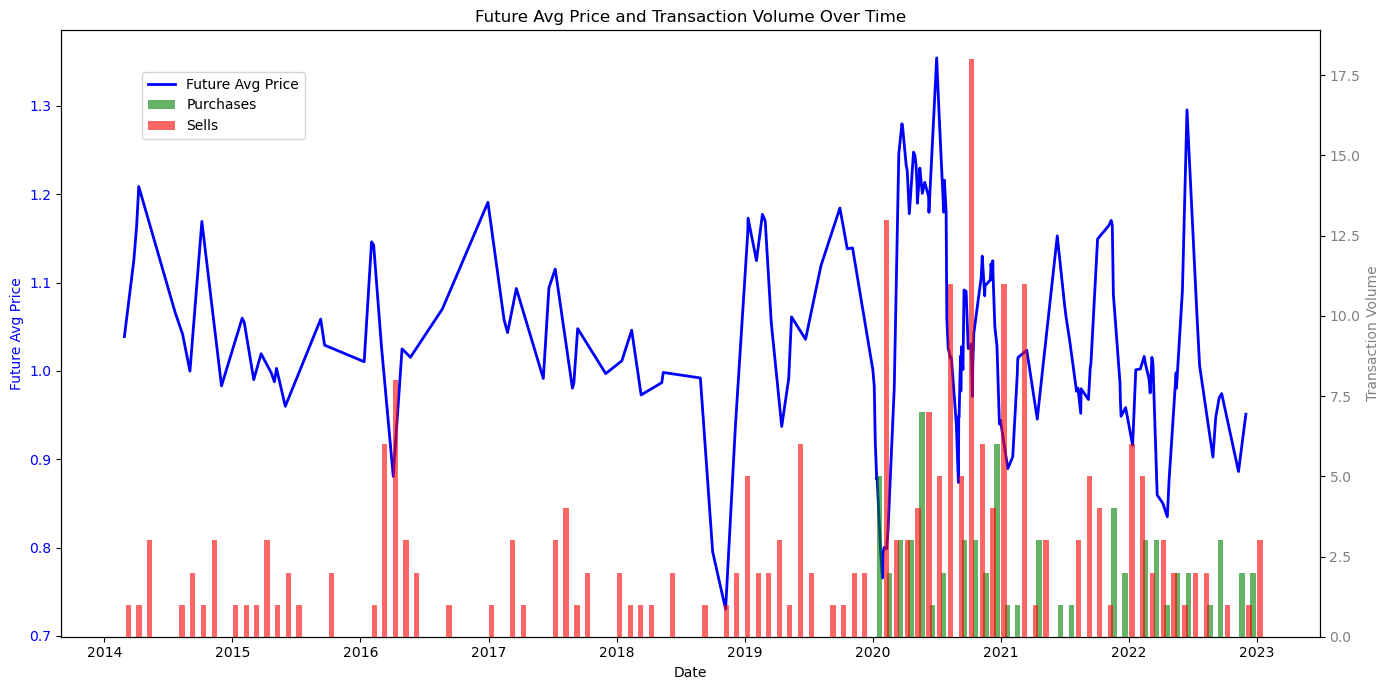

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'Date' is the index and in datetime format
if valid_data_df.index.name != 'Date':
    raise ValueError("The index of valid_data_df must be 'Date'!")

# Step 1: Aggregate transaction counts over time (monthly)
transaction_counts = (
    valid_data_df.explode('type')  # Separate multiple transactions per day
    .groupby([pd.Grouper(freq='M', level=0), 'type'])  # Group by month and type using the index
    .size()
    .unstack(fill_value=0)  # Reshape to have 'type' as columns
)

# Rename columns for better readability
transaction_counts.columns = ['Sells', 'Purchases']

# Step 2: Plot future average price and transaction volumes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot future average price
ax1.plot(valid_data_df.index, valid_data_df['future_avg_price'], label='Future Avg Price', color='blue', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Future Avg Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Future Avg Price and Transaction Volume Over Time')

# Create a secondary y-axis for transaction counts
ax2 = ax1.twinx()

# Adjust bar width and offsets
width = np.timedelta64(10, 'D')  # Offset width for separation (10 days)

# Plot Purchases
ax2.bar(
    transaction_counts.index - width,  # Shift purchases bars to the left
    transaction_counts['Purchases'],
    color='green',
    alpha=0.6,
    width=15,  # Reduce bar width
    label='Purchases'
)

# Plot Sells
ax2.bar(
    transaction_counts.index + width,  # Shift sells bars to the right
    transaction_counts['Sells'],
    color='red',
    alpha=0.6,
    width=15,  # Reduce bar width
    label='Sells'
)

# Set y-axis label for transactions
ax2.set_ylabel('Transaction Volume', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Add legends for both plots
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()


Analyzing Transaction Trends Over Time and by Political Party

This code performs the following analyses:
1. Displays the monthly trading activity for all transaction types, showing temporal patterns.
2. Visualizes monthly trading activity broken down by transaction type (e.g., purchase, sell) specifically for the Republican Party.
3. Similar analysis as above but focused on the Democratic Party, highlighting differences or similarities in their trading patterns.


<Figure size 1200x600 with 0 Axes>

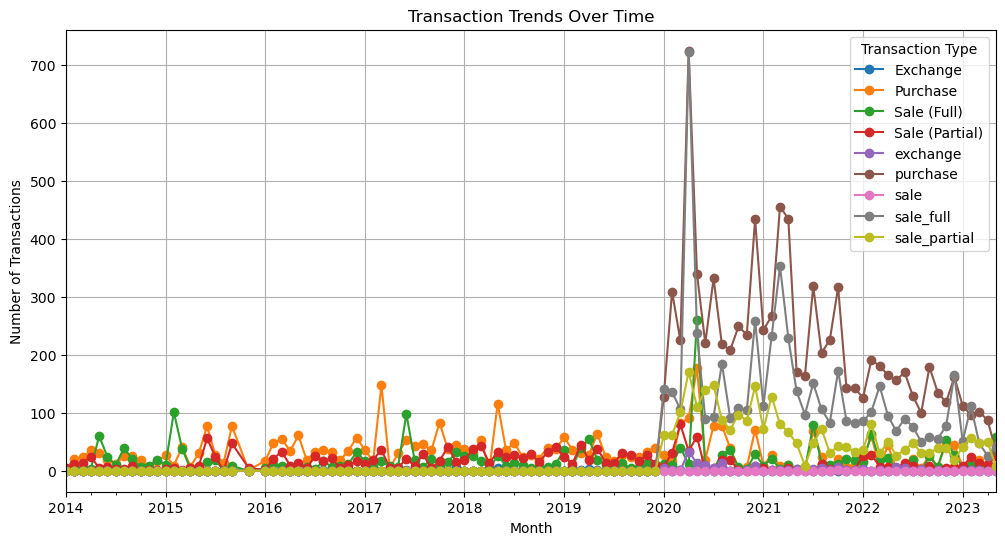

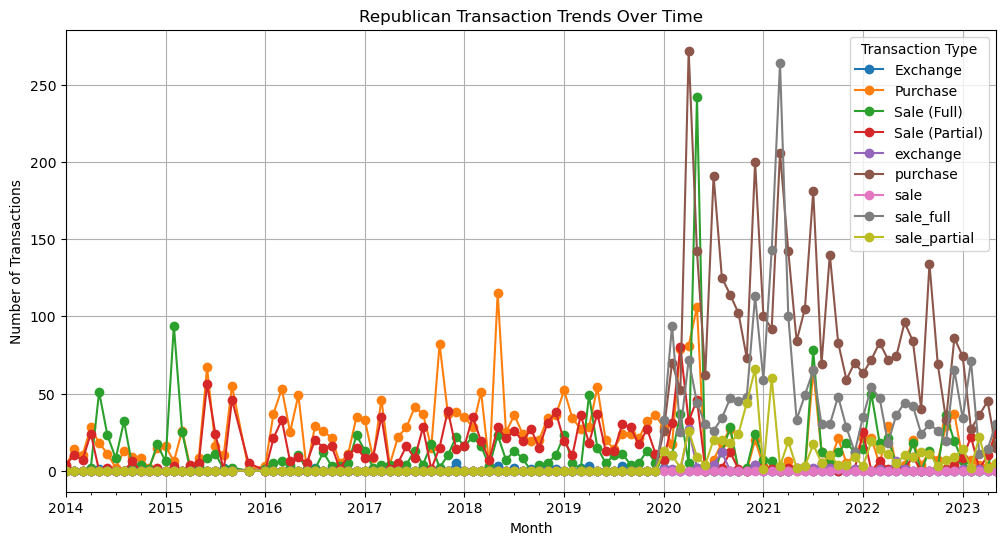

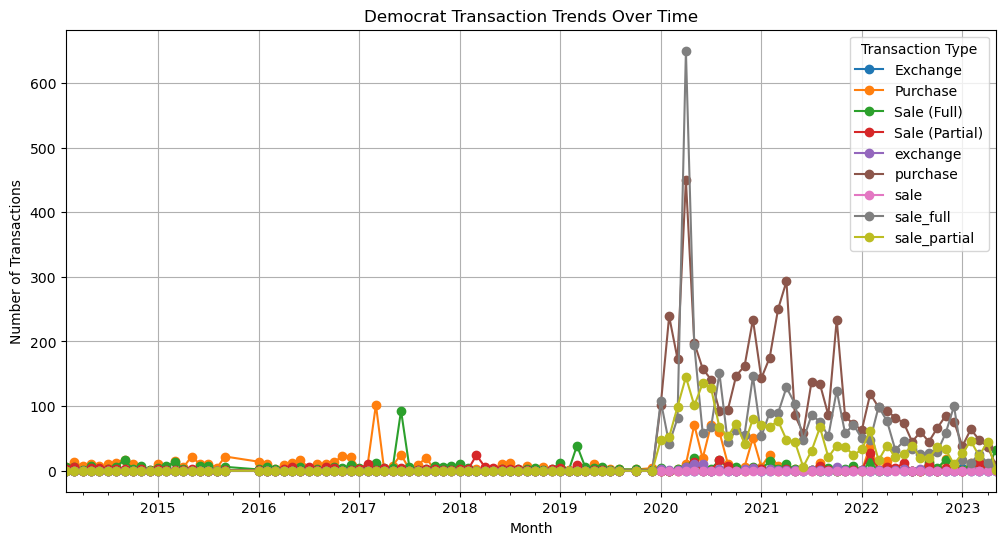

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure disclosure_date is in datetime format
df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], format='%Y-%m-%d')

# Add columns for Year and Month
df['Year'] = df['disclosure_date'].dt.year
df['Month'] = df['disclosure_date'].dt.to_period('M')  # Year-Month format

# Group by Month and Transaction Type
monthly_trends = df.groupby(['Month', 'type'])['type'].count().unstack(fill_value=0)

# Plot Transaction Trends Over Time (All Types)
plt.figure(figsize=(12, 6))
monthly_trends.plot(kind='line', figsize=(12, 6), marker='o', title='Transaction Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid()
plt.show()

# Group by Political Party and Transaction Type
party_trends = df.groupby(['Month', 'party', 'type']).size().unstack(fill_value=0)

# Example: Plot Trends for Republicans
republican_trends = party_trends.loc[party_trends.index.get_level_values('party') == 'Republican']
republican_trends.droplevel('party').plot(kind='line', figsize=(12, 6), marker='o', title='Republican Transaction Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid()
plt.show()

# Example: Plot Trends for Democrats
democrat_trends = party_trends.loc[party_trends.index.get_level_values('party') == 'Democrat']
democrat_trends.droplevel('party').plot(kind='line', figsize=(12, 6), marker='o', title='Democrat Transaction Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid()
plt.show()


Analyzing Transaction Activity by Sector

This code visualizes congressional trading activity by sector, highlighting:
1. Total transaction counts per sector to identify the most traded industries.
2. Trends over time for the top 5 sectors, showing temporal patterns in trading behavior.


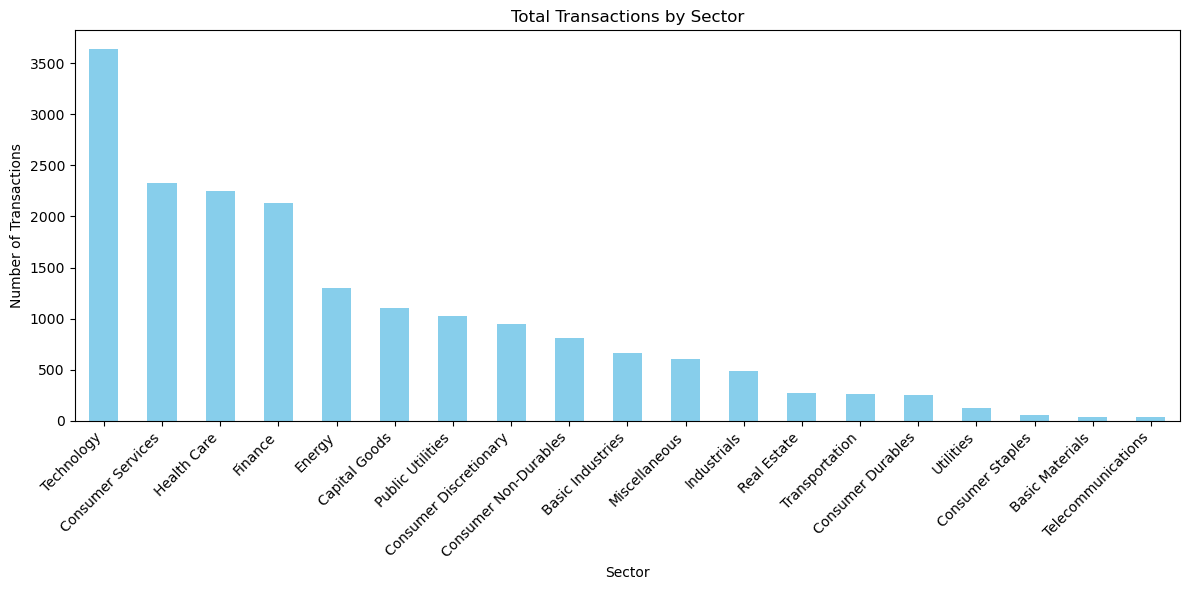

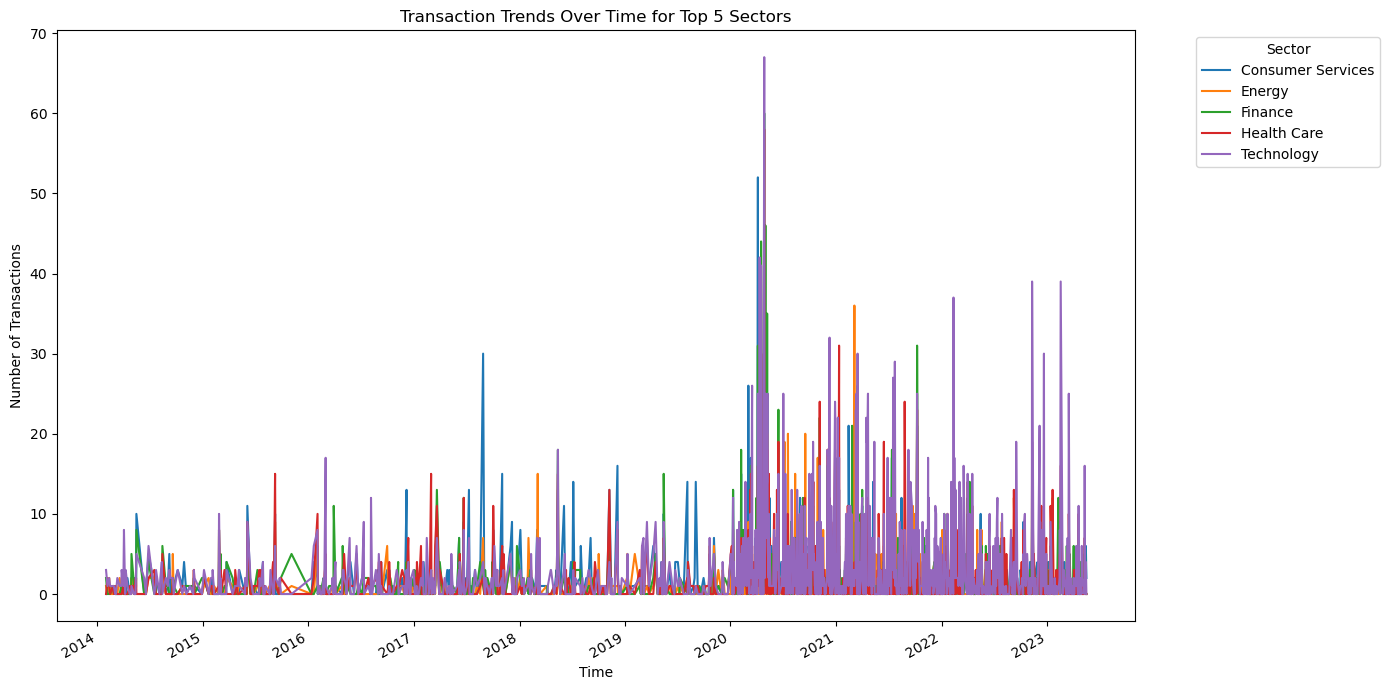

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Grouping by sector and calculating the transaction counts
sector_summary = df.groupby('sector')['type'].value_counts().unstack(fill_value=0)

# Plotting total transaction counts per sector
plt.figure(figsize=(12, 6))
sector_summary.sum(axis=1).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Total Transactions by Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyzing trends over time for top 5 sectors
top_sectors = sector_summary.sum(axis=1).sort_values(ascending=False).head(5).index

# Filtering data for top sectors
top_sectors_data = df[df['sector'].isin(top_sectors)]

# Grouping by sector and date for trends
sector_trends = top_sectors_data.groupby(['disclosure_date', 'sector'])['type'].count().unstack(fill_value=0)

# Plotting trends
sector_trends.plot(figsize=(14, 7))
plt.title('Transaction Trends Over Time for Top 5 Sectors')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [98]:

print(merged_df.columns)

Index(['Date', 'future_avg_price', 'type', 'amount', 'rsi', 'macd_diff'], dtype='object')


In [ ]:
#For feature engineering, the features we will be using will be Date, future average price, type, amount, rsi and mac_diff

In [108]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')


# Filter for rows with valid transaction data
valid_data_df = merged_df[
    (merged_df['type'].apply(lambda x: len(x) > 0)) | 
    (merged_df['amount'].apply(lambda x: len(x) > 0))
]

# Clean the Data
valid_data_df['rsi'] = valid_data_df['rsi'].fillna(valid_data_df['rsi'].mean())
valid_data_df['macd_diff'] = valid_data_df['macd_diff'].fillna(valid_data_df['macd_diff'].mean())

# Ensure 'type' and 'amount' are not empty
valid_data_df['type'] = valid_data_df['type'].apply(lambda x: [0] if not x else x)
valid_data_df['amount'] = valid_data_df['amount'].apply(lambda x: [0] if not x else x)

# Feature Engineering
# Add temporal features
valid_data_df['Year'] = valid_data_df['Date'].dt.year
valid_data_df['Month'] = valid_data_df['Date'].dt.month
valid_data_df['Day'] = valid_data_df['Date'].dt.day
valid_data_df['Quarter'] = valid_data_df['Date'].dt.quarter
valid_data_df['is_weekend'] = valid_data_df['Date'].dt.weekday >= 5

# Create lagged features and rolling averages
valid_data_df['price_t-1'] = valid_data_df['future_avg_price'].shift(1)
valid_data_df['7_day_rolling_avg'] = valid_data_df['future_avg_price'].rolling(window=7).mean()
valid_data_df['price_pct_change'] = valid_data_df['future_avg_price'].pct_change()

# Encode transaction types and map 'amount' ranges
valid_data_df['type_encoded'] = valid_data_df['type'].apply(lambda x: sum(x))
amount_mapping = {
    '$1,001 - $15,000': 1,
    '$15,001 - $50,000': 2,
    '$50,001 - $100,000': 3,
    '$100,001 - $250,000': 4,
    '$250,001 - $500,000': 5,
    '$500,001 - $1,000,000': 6,
}
valid_data_df['amount_numeric'] = valid_data_df['amount'].apply(
    lambda x: [amount_mapping.get(i, 0) for i in x]
)

# Add momentum indicators
valid_data_df['rsi_above_50'] = valid_data_df['rsi'] > 50
valid_data_df['macd_positive'] = valid_data_df['macd_diff'] > 0

# Create interaction features
valid_data_df['rsi_macd_interaction'] = valid_data_df['rsi'] * valid_data_df['macd_diff']
valid_data_df['price_rsi_interaction'] = valid_data_df['future_avg_price'] * valid_data_df['rsi']

# Normalize or Scale Numerical Data
scaler = StandardScaler()
numeric_cols = ['future_avg_price', 'price_t-1', '7_day_rolling_avg', 'rsi', 'macd_diff']
valid_data_df[numeric_cols] = scaler.fit_transform(valid_data_df[numeric_cols])





/var/folders/ly/f_skbhmj0y7cmdbd9hc068d80000gn/T/ipykernel_36316/4283199925.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_df['rsi'] = valid_data_df['rsi'].fillna(valid_data_df['rsi'].mean())
/var/folders/ly/f_skbhmj0y7cmdbd9hc068d80000gn/T/ipykernel_36316/4283199925.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_df['macd_diff'] = valid_data_df['macd_diff'].fillna(valid_data_df['macd_diff'].mean())
/var/folders/ly/f_skbhmj0y7cmdbd9hc068d80000gn/T/ipykernel_36316/4283199925.

This histogram illustrates the distribution of the Relative Strength Index (RSI) values across the dataset. RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions in a stock. The histogram provides insights into the central tendency and variability of RSI values, helping identify trends or extreme values. A normal distribution of RSI values indicates balanced momentum, while skewed distributions may highlight anomalies in the market.

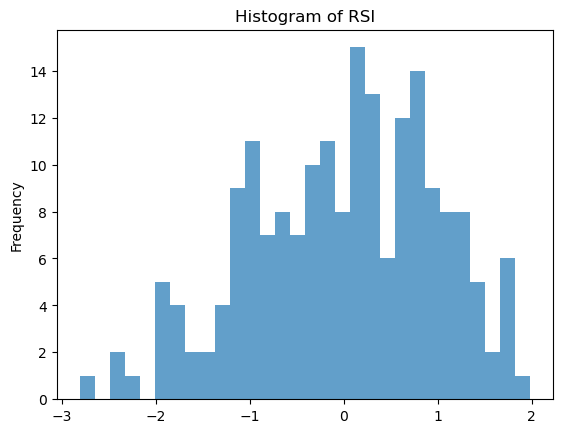

In [105]:
# Histogram of RSI
valid_data_df['rsi'].plot(kind='hist', bins=30, title='Histogram of RSI', alpha=0.7)
plt.show()


This line plot compares the actual future average prices of the stock (future_avg_price) with a 7-day rolling average. The rolling average smooths out short-term fluctuations to reveal long-term trends. By overlaying these two lines, this visualization highlights price trends and anomalies over time.


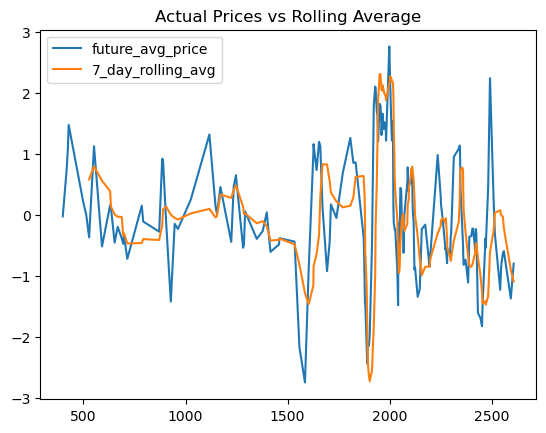

In [106]:
# Rolling Average vs Actual Prices
valid_data_df[['future_avg_price', '7_day_rolling_avg']].plot(title='Actual Prices vs Rolling Average')
plt.show()

This scatter plot examines the relationship between RSI and MACD Diff (the difference between the MACD line and the signal line). RSI captures momentum, while MACD indicates trend strength and direction. A positive correlation in this plot suggests that higher momentum (RSI) corresponds to stronger bullish trends (positive MACD Diff).

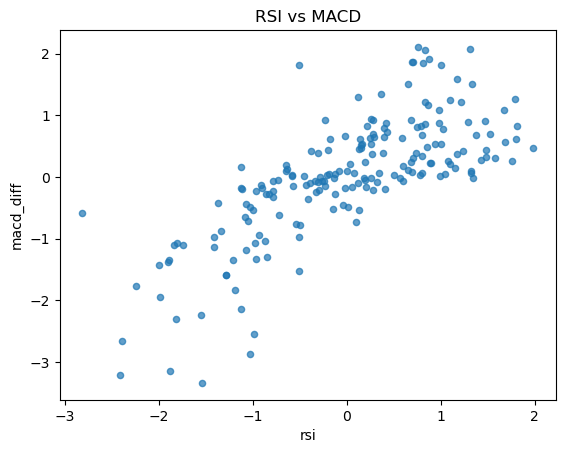

In [107]:
# RSI vs MACD Interaction
valid_data_df.plot(x='rsi', y='macd_diff', kind='scatter', title='RSI vs MACD', alpha=0.7)
plt.show()